In [148]:
#!pip install classiq
from classiq import *
import classiq
#classiq.authenticate()
import numpy as np


In [186]:
size = 4 # for 16 noodes
#size = 2

In [161]:
@qfunc

def prepare_minus(x: QBit): # prepare qubit for minus state |->
  X(x) # apply x gate
  H(x) # apply H gate.


In [162]:
@qfunc
def diffuzer_oracle(aux: Output[QNum], x:QNum): # modify aux based on x.
  aux^= (x!=0)

In [163]:
@qfunc
def zero_diffuzer(x: QNum): # prepare aux qubtin in negative state and apply diffuzer_oracle.
  aux = QNum("aux")
  allocate(1, aux)
  within_apply(compute = lambda: prepare_minus(aux),
               action = lambda: diffuzer_oracle)


In [192]:
def W_iteration(i:int, vertices: QNum, adjacent_vertices:QNum):

  # prepare the probability vector for the node , prepare state, then apply zero diffuzer.

  #prob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] # 16
 #prob = [0,0,0,0] # 4
  #prob[(i+1)%4] = 0.5 ##
  #prob[(i-1)%4] = 0.5
  #prob[(i+1)%size] = 0.5
  #prob[(i-1)%size] = 0.5

  prob = [0] * (2**size)

  if i == 0: # first qubit
    prob[i+1] = 1.0
  elif i == (2**size)- 1: # last qubit
    prob[i-1] = 1.0
  else: # all other qubits
    prob[(i-1)] = 0.5
    prob[(i+1)] = 0.5


  print(f"State={i}, prob vec={prob}")

  control(ctrl=vertices==i,
          operand=lambda: within_apply(
              compute = lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices), # prepare desired states we want.
              action= lambda: zero_diffuzer(adjacent_vertices)))

@qfunc
def W_operator(vertices:QNum, adjacent_vertices: QNum):
  for i in range(2**size):
    W_iteration(i, vertices, adjacent_vertices) # apply W_iterations to nodes.

In [193]:
@qfunc
def edge_oracle(res:Output[QBit], vertices:QNum, adjacent_vertices: QNum):
  res |= (((vertices+adjacent_vertices)%2) ==1) # checking if edge between vertices and adj vertices is odd or even.

#make the there is only a diff of 1 between the nodes.

## this might be responsible for the number of edges.
## oralce is graph depended.

In [194]:
@qfunc
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i])) # SWAP indexes of x and y.

In [195]:
@qfunc
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices) #applying the edge_oracle
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices)) ## apply the bitwise swap of vertices and adj vertices.

#

In [196]:
@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices) # create 4 qubits for vertices
  hadamard_transform(vertices) # apply H gates to all vertices.
  allocate(size,adjacent_vertices) # create 4 qubits for adj vertices

  W_operator(vertices,adjacent_vertices) # apply W_operator to vertices and adj vertices
  S_operator(vertices,adjacent_vertices) # apply S_operator to vertices and adj vertices

qmod = create_model(main) # creating model on Classiq platform.
qprog = synthesize(qmod) # snythesize the code on Classiq platform.
show(qprog)

State=0, prob vec=[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec=[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec=[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec=[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec=[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec=[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec=[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec=[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec=[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec=[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Stat

In [197]:
## Below is the quantum program from classiq.

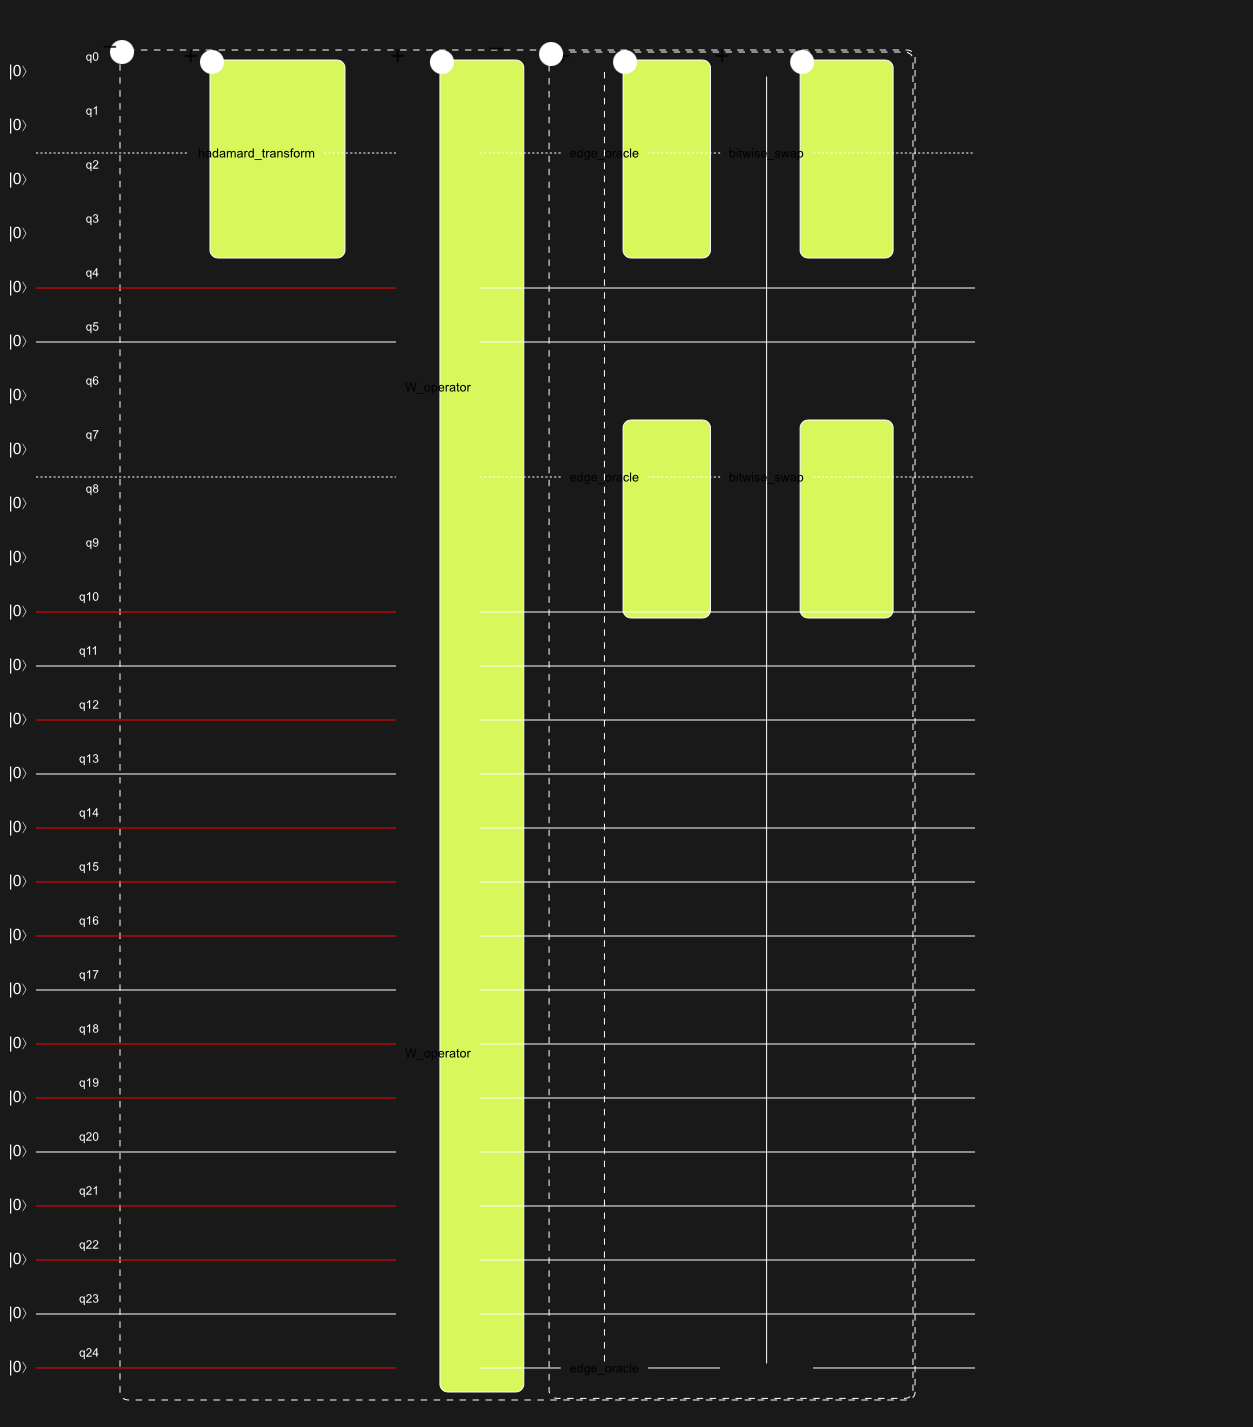

In [198]:
## below is the measurement result with the use of the simulator from Classiq.

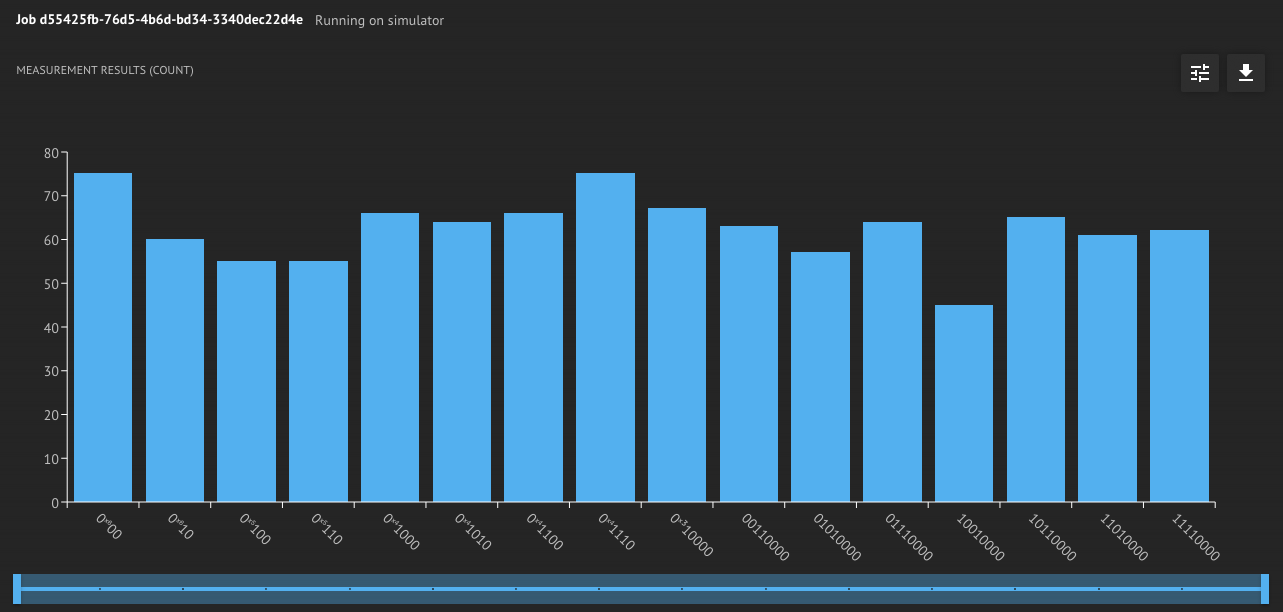

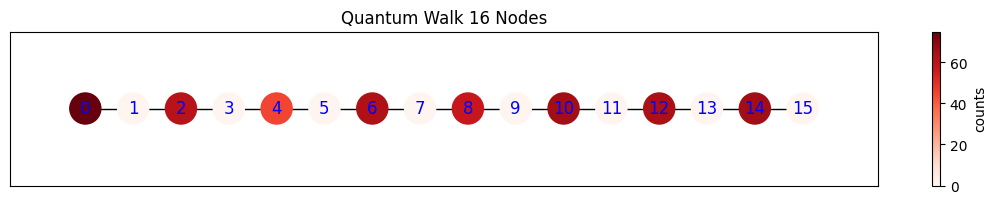

In [210]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.path_graph(16) # creating path graph with 16 nodes in a line.
pos = {i :(i,0) for i in range(16)}

state = ['10010000', '10110000', '11010000', '11110000', '00001010', '00001100', '00001110', '00000000',
          '01010000', '00000110', '00001000', '00110000', '00000100', '00010000', '00000010', '01110000'] # from measurement results classiq.
count = [75, 60, 55, 55, 66, 64, 66, 75, 67, 63, 57, 64, 45, 65, 61, 62] # from measurement results classiq.

vertex_counts = {int(state, 2): count for state, count in zip(state, count)} # extrating vertex counts.

colors = [vertex_counts.get(node, 0) for node in G.nodes()] #color brightness based on vertex counts.

fig, ax = plt.subplots(figsize=(14,2)) # size of plot.
nodes = nx.draw_networkx_nodes(G, pos, node_size = 500, node_color= colors, cmap = plt.cm.Reds) # draw path graph with given parameters.
nx.draw_networkx_edges(G, pos, ax=ax)
nx.draw_networkx_labels(G, pos, font_color='blue', ax=ax)

plt.title("Quantum Walk 16 Nodes")
plt.colorbar(nodes, label='counts')
plt.show() # show the plot